## Demonstration of loading and plotting pseudo-lapse rate data for the Uinta Basin
The approach is:

* Download data from Synoptic Weather (load if already downloaded)

In [1]:
import datetime
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from obs.download_gather_winters import download_winter_obs
from obs.io_utils import load_data_for_years
from obs.obsdata import ObsData
from preprocessing.pseudo_lapse_rate import compute_pseudo_lapse_rate
from preprocessing.representative_obs import do_repval_ozone
from viz.plotting import visualize_station_locations
from viz.profile_plots import compute_max_temp_profile
import utils.utils as utils 

/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/synoptic/accessors.py:28: UserWarning: map making not available without Brian's cartopy_tools
  warnings.warn("map making not available without Brian's cartopy_tools")


In [2]:
# SETTINGS
redownload = False

fdir = "../data_seth"
qc = "all"
start_month = 12
end_month = 3
start_day = 1
end_day = 15
start_year = 2022
end_year = 2023
obs_vars = ["wind_speed", "wind_direction", "air_temp", "dew_point_temperature", "pressure", "snow_depth", 
                "solar_radiation", "altimeter", "soil_temp", "sea_level_pressure", "snow_accum", "ceiling", 
                "soil_temp_ir", "snow_smoothed", "snow_accum_manual", "snow_water_equiv", "net_radiation_sw", 
                "sonic_air_temp", "sonic_vertical_vel", "vertical_heat_flux", "outgoing_radiation_sw", 
                "PM_25_concentration", "ozone_concentration", "derived_aerosol_boundary_layer_depth", 
                "NOx_concentration", "PM_10_concentration"]
years = np.arange(start_year+1, end_year+1, dtype=int)


In [3]:
# GEOGRAPHIC INFORMATION/SETTINGS
towns = {
    "Vernal": [40.4555, -109.5287],
    "Roosevelt": [40.2994, -109.9888],
    "Duschene (KU69)": [40.1919, -110.38099],
    "Fruitland (UTFRT)": [40.20525, -110.77125],
    "Strawberry/US-40 (UTCOP)": [40.2418, -111.1771],
    "Five Mile (FIVU1)": [39.89089, -110.266], 
    "Dinosaur (SURC2)": [40.51056, -108.93417],
}

elevations = {
    "Ouray": 1425,
    "Vernal": 1622,
    "Hanna": 2062,
    "Split Mtn": 2294,
    "Kings Pk": 4123,
}

# lat/lon extents for map 
extent = [-111.25, -108.9, 39.4, 41.05]

# Elevation bins for filtering in blocks to remove outliers
elev_bins = np.arange(1000, 4001, 250)


In [4]:
# If data folder doesn't exist, create it and download data. 
if not os.path.exists(fdir) or redownload:
    os.makedirs(fdir, exist_ok=True)
    download_winter_obs(start_year, end_year, start_month, end_month, start_day, end_day, obs_vars, fdir, qc)
    

In [5]:
# Hard coded file naming, for now.
df, meta_df = ObsData.load_dfs(fdir, f"UB_obs_{int(end_year):d}.parquet")
df.head(10)

,air_temp,altimeter,ceiling,dew_point_temperature_set_1,dew_point_temperature,pressure,sea_level_pressure_set_1,sea_level_pressure,wind_direction,wind_speed,...,solar_radiation,dew_point_temperature_set_1d,soil_temp,soil_temp_set_2,soil_temp_set_3,soil_temp_set_4,soil_temp_set_5,NOx_concentration,ozone_concentration,PM_25_concentration
date_time,,,,,,,,,,,,,,,,,,,,,
2022-12-01 00:00:00+00:00,-5.0,101693.203125,NaN,NaN,-12.11,83777.976562,NaN,102371.351562,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:05:00+00:00,-3.0,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102188.390625,270.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:10:00+00:00,-3.0,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102188.390625,260.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:15:00+00:00,-3.0,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102188.390625,270.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:20:00+00:00,-4.0,101659.335938,NaN,NaN,-12.12,83750.093750,NaN,102262.531250,260.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:25:00+00:00,-7.0,101659.335938,NaN,NaN,-13.09,83750.093750,NaN,102488.578125,240.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:30:00+00:00,-6.0,101659.335938,NaN,NaN,-12.09,83750.093750,NaN,102412.609375,230.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:35:00+00:00,-7.0,101659.335938,NaN,NaN,-12.08,83750.093750,NaN,102488.562500,270.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-01 00:40:00+00:00,-6.0,101659.335938,NaN,NaN,-12.09,83750.093750,NaN,102412.609375,280.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
meta_df

,KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,...,4276P,PC266,PC353,UB1UT,PC486,UGSDV,UTELP,UTMTH,PC558,PC561
DISTANCE,20.26,22.29,40.84,32.16,39.04,37.87,37.27,42.98,34.35,21.18,...,26.36,25.48,16.98,15.51,29.22,15.57,17.01,40.08,23.64,30.35
ELEVATION,5262.0,5151.0,5725.0,9552.0,9448.0,7730.0,7484.0,6722.0,6469.0,5240.0,...,4803.0,8426.0,5947.0,5070.0,6149.0,5032.0,5692.0,6695.0,5818.0,5364.0
ELEV_DEM,5269.0,5200.1,5590.6,9583.3,9471.8,7729.7,7483.6,6702.8,6423.9,5226.4,...,NaN,8441.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ID,61,878,902,1494,1509,2336,2337,2348,2360,2365,...,173578,175633,217351,237823,238714,239856,243538,245316,245317,245375
MNET_ID,1,1005,19,25,25,2,2,2,2,2,...,208,247,247,153,247,153,4,4,247,247
NAME,Vernal Airport,ROOSEVELT-UNION HS,STARVATION DAM,MOSBY MTN.,TROUT CREEK,DIAMOND RIM,FIVE MILE,MCCOOK RIDGE,UPPER SAND WASH,YAMPA PLATEAU,...,Dino Ozone Station,Little Mountain,Vernal West,CIGE 226,Little Valley,Desert View (Myton) EC,SR-121 at MP 31.5 East Lapoint,SR-87 at MP 16 Mountain Home,Ashley,Duchesne River
RECORD_END,2024-10-16 22:05:00+00:00,2002-02-13 21:00:00+00:00,NaT,2024-10-16 21:00:00+00:00,2024-10-16 21:00:00+00:00,2024-10-16 21:27:00+00:00,2024-10-16 21:28:00+00:00,2024-10-16 21:27:00+00:00,2024-10-16 21:27:00+00:00,2024-10-16 21:27:00+00:00,...,2022-05-27 03:10:00+00:00,2024-10-16 22:10:00+00:00,2024-10-16 22:10:00+00:00,2024-10-16 21:15:00+00:00,2024-10-16 22:10:00+00:00,2024-10-16 22:00:00+00:00,2024-10-16 22:00:00+00:00,2024-10-16 22:00:00+00:00,2024-10-16 22:10:00+00:00,2024-10-16 22:10:00+00:00
RECORD_START,1997-01-01 00:00:00+00:00,1999-01-12 00:00:00+00:00,NaT,2000-01-20 00:00:00+00:00,2000-01-20 00:00:00+00:00,1997-01-01 00:00:00+00:00,1997-05-27 00:00:00+00:00,1997-01-01 00:00:00+00:00,1997-01-01 00:00:00+00:00,1997-01-01 00:00:00+00:00,...,2022-04-26 21:10:00+00:00,2022-06-30 20:15:00+00:00,2023-05-16 08:14:00+00:00,2024-05-13 18:00:00+00:00,2024-06-11 07:40:00+00:00,2024-07-12 19:30:00+00:00,2024-08-23 00:40:00+00:00,2024-09-26 20:40:00+00:00,2024-09-27 07:40:00+00:00,2024-10-03 07:30:00+00:00
RESTRICTED,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
STATE,UT,UT,UT,UT,UT,UT,UT,UT,UT,UT,...,UT,UT,UT,UT,UT,UT,UT,UT,UT,UT


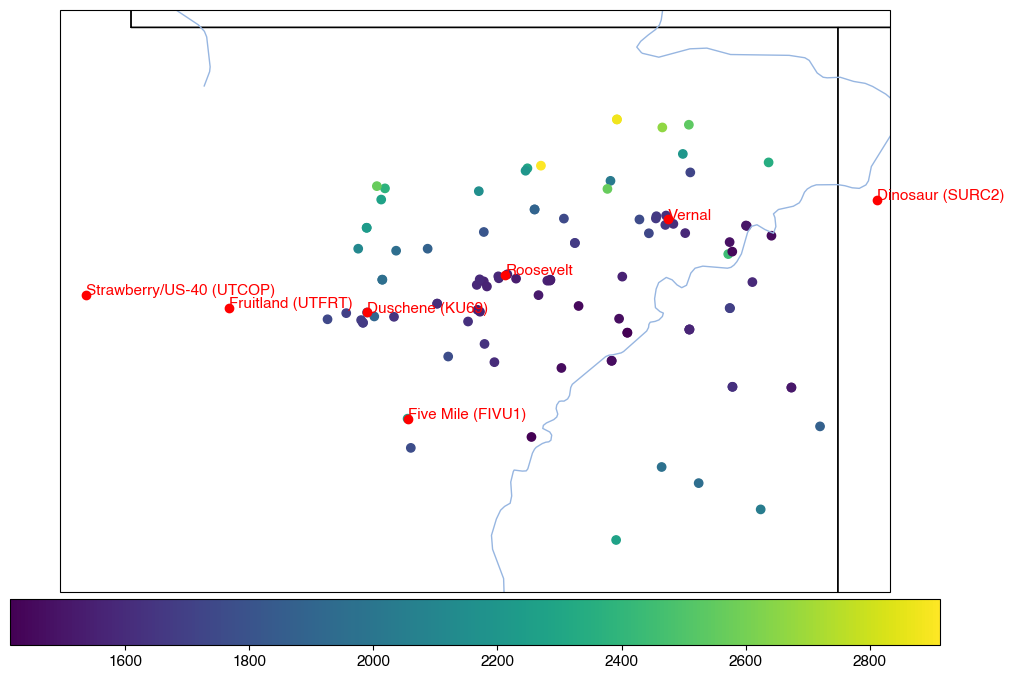

In [7]:
visualize_station_locations(meta_df, towns, extent)

In [8]:
# Look up stats about temperature obs in the dataset
vrbl = "air_temp"
year_counts_df = load_data_for_years(fdir, years, vrbl)
print(year_counts_df)

# These are the stids with the vrbl we want
vrbl_stids = {year: year_counts_df.loc[year, "stid_string"].split(",") for year in years}

# Finds stations that have reported temperature data for at least 3 years
common_temp_stids = utils.find_common_stids(vrbl_stids, years, 3)
print(len(common_temp_stids))

      stids                                        stid_string
2023    108  KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,U...
108


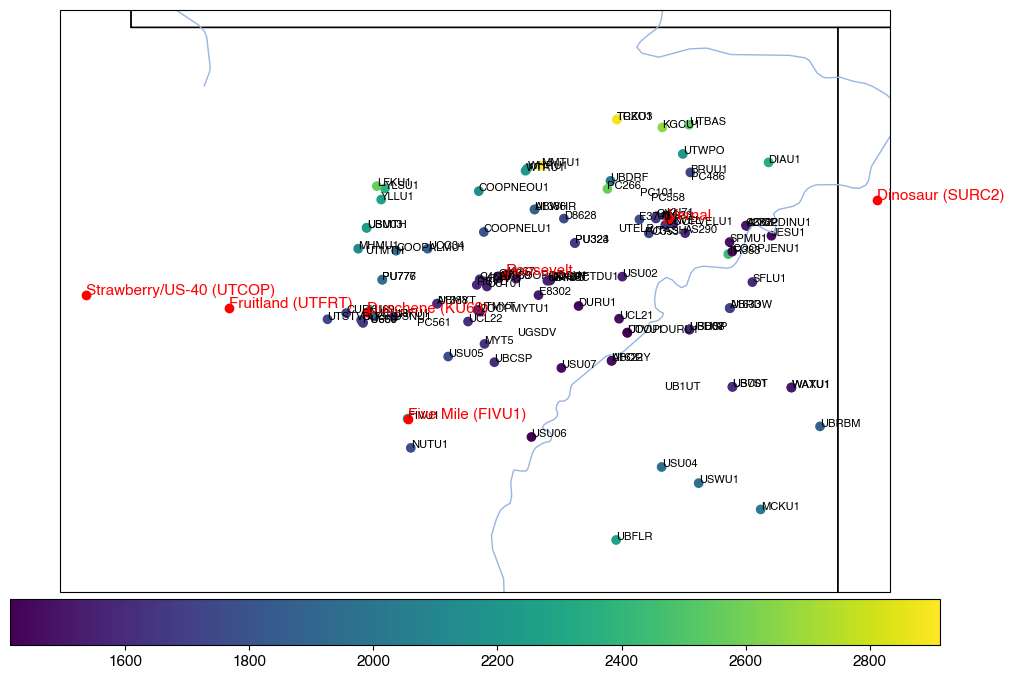

In [9]:
visualize_station_locations(meta_df, towns, extent, only_stids=list(common_temp_stids), stid_name=True)

In [10]:
# For the data, subset the dataframe to those with stid in common_temp_stids
common_temp_df = df[df["stid"].isin(common_temp_stids)]

# Do tests for this day (max temp in this solar day)
example_date = "2022-12-01"

max_temp = compute_max_temp_profile(common_temp_df, meta_df, example_date)
max_temp

,stid,local_day,max_air_temp,elevation
9177,USU06,2022-12-01,35.571999,1414.2688
10206,UTVU1,2022-12-01,-3.528000,1421.2608
1442,COOPJENU1,2022-12-01,-4.444000,1439.2272
2393,DURU1,2022-12-01,2.778000,1447.1920
2813,JESU1,2022-12-01,-1.900000,1453.1808
...,...,...,...,...
3523,LFKU1,2022-12-01,1.000000,2566.2464
3020,KGCU1,2022-12-01,-0.200000,2662.9792
6031,TCKU1,2022-12-01,-1.400000,2879.4272
6240,TRZO3,2022-12-01,2.778000,2879.4272


Pseudo-lapse rate: 0.15 °C/km


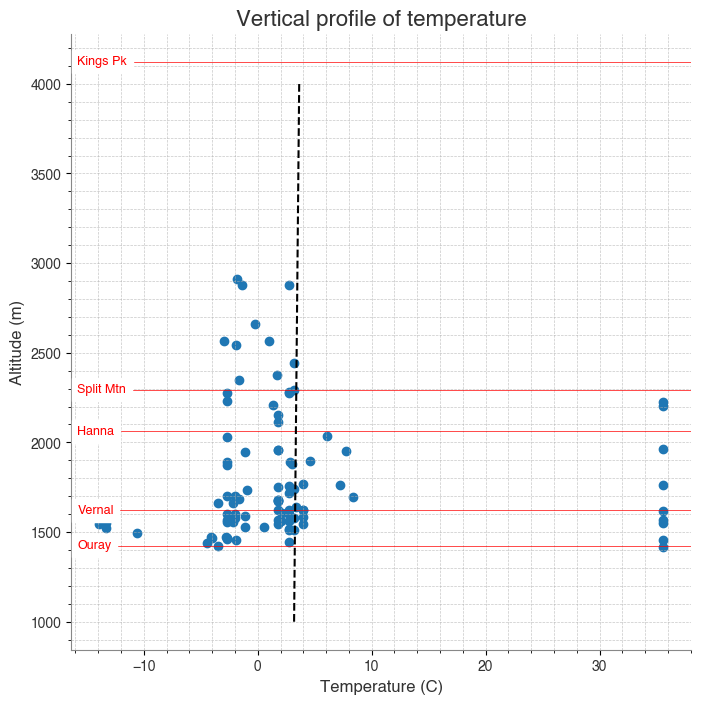

In [11]:
# No filtering 
lapse_rate = compute_pseudo_lapse_rate(max_temp, elevations, do_filter=False)

Pseudo-lapse rate: 1.01 °C/km


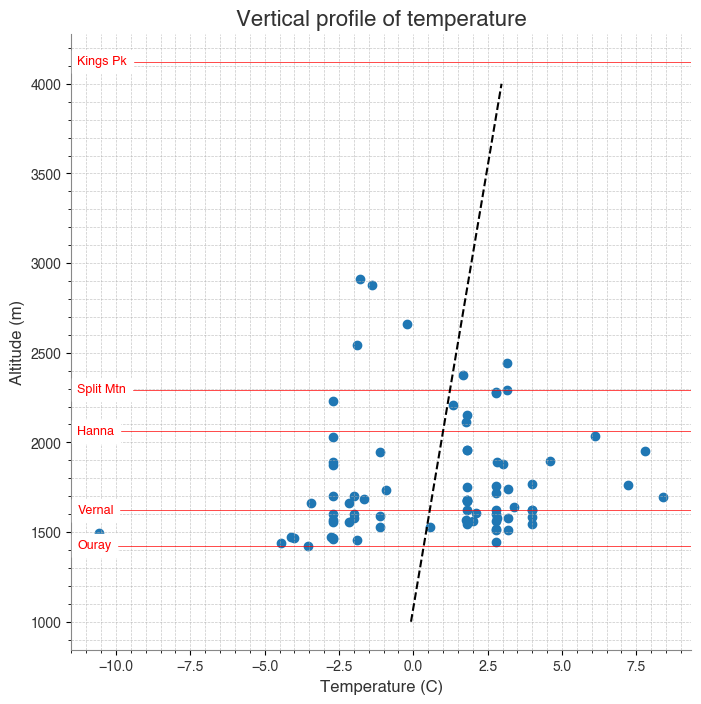

In [12]:
# Some filtering 
lapse_rate = compute_pseudo_lapse_rate(max_temp, elevations, do_filter=True, elev_bins=elev_bins, num_std_dev=1)

In [13]:
# Go through the year and compute the lapse rate for each day (no figure plotted) 

# Initialize the dataframe to store the lapse rates
lapse_rate_list = []

start_date = f"{start_year}-12-01"
# end_date = f"{start_year}-12-30"
end_date = f"{end_year}-03-01"

for date in pd.date_range(start_date, end_date):
    max_temp = compute_max_temp_profile(common_temp_df, meta_df, date.strftime("%Y-%m-%d"))
    lapse_rate = compute_pseudo_lapse_rate(max_temp, elevations, do_filter=True, elev_bins=elev_bins, num_std_dev=1, do_plot=False)
    lapse_rate_list.append({"date": date, "lapse_rate": lapse_rate})

# Convert the list to a DataFrame
lapse_rate_df = pd.DataFrame(lapse_rate_list)

# Get ozone 
ozone_subdf = df[df["stid"].isin(["UBHSP", "QV4", "QRS"])][["ozone_concentration","stid"]] # .loc[start_date:end_date]

repr_ozone = do_repval_ozone(ozone_subdf)

lapse_rate_df

Pseudo-lapse rate: 1.01 °C/km
Pseudo-lapse rate: -2.87 °C/km
Pseudo-lapse rate: 0.84 °C/km
Pseudo-lapse rate: 0.60 °C/km
Pseudo-lapse rate: -0.43 °C/km
Pseudo-lapse rate: -1.16 °C/km
Pseudo-lapse rate: 1.43 °C/km
Pseudo-lapse rate: 0.80 °C/km
Pseudo-lapse rate: 2.46 °C/km
Pseudo-lapse rate: 3.95 °C/km
Pseudo-lapse rate: 4.77 °C/km
Pseudo-lapse rate: -1.48 °C/km
Pseudo-lapse rate: -0.39 °C/km
Pseudo-lapse rate: 3.04 °C/km
Pseudo-lapse rate: 0.48 °C/km
Pseudo-lapse rate: 2.57 °C/km
Pseudo-lapse rate: 5.99 °C/km
Pseudo-lapse rate: 7.76 °C/km
Pseudo-lapse rate: 8.64 °C/km
Pseudo-lapse rate: 6.20 °C/km
Pseudo-lapse rate: 2.74 °C/km
Pseudo-lapse rate: -3.35 °C/km
Pseudo-lapse rate: 4.54 °C/km
Pseudo-lapse rate: 6.50 °C/km
Pseudo-lapse rate: 6.57 °C/km
Pseudo-lapse rate: 7.55 °C/km
Pseudo-lapse rate: 4.15 °C/km
Pseudo-lapse rate: -0.61 °C/km
Pseudo-lapse rate: -0.51 °C/km
Pseudo-lapse rate: 0.51 °C/km
Pseudo-lapse rate: 0.65 °C/km
Pseudo-lapse rate: -1.52 °C/km
Pseudo-lapse rate: -1.75 °C/km


,date,lapse_rate
0,2022-12-01,1.014997
1,2022-12-02,-2.870692
2,2022-12-03,0.837426
3,2022-12-04,0.596578
4,2022-12-05,-0.431481
...,...,...
86,2023-02-25,4.550483
87,2023-02-26,1.328684
88,2023-02-27,-5.964029
89,2023-02-28,-3.728680


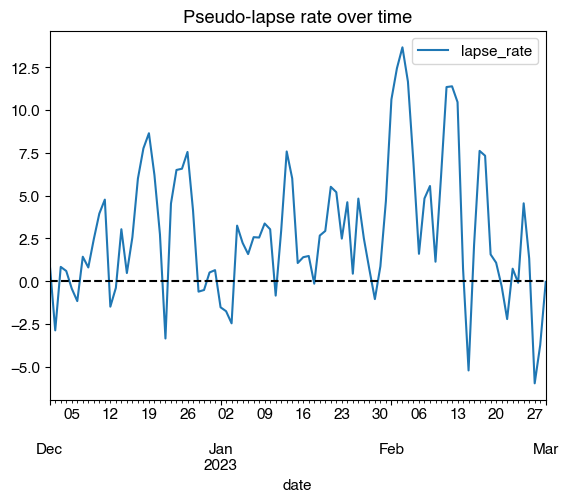

In [14]:
# Plot lapse rate over time 
lapse_rate_df.plot(x="date", y="lapse_rate", title="Pseudo-lapse rate over time")
# Horizontal line at y=0 
plt.axhline(0, color="black", linestyle="--")

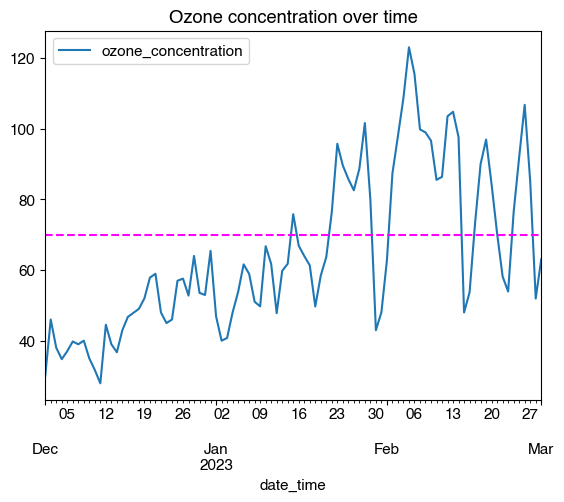

In [15]:
# Plot ozone over same time (start_date to end_date)
repr_ozone.loc[start_date:end_date].plot(title="Ozone concentration over time")
plt.axhline(70, color="magenta", linestyle="--")
